In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone

In [2]:
# leitura do arquivo
bh = pd.read_csv('data.csv')
bh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        5981 non-null   object 
 1   adm-fees       3977 non-null   float64
 2   garage-places  5981 non-null   object 
 3   price          5951 non-null   float64
 4   rooms          5981 non-null   object 
 5   square-foot    5981 non-null   object 
 6   neighborhood   5957 non-null   object 
 7   city           5981 non-null   object 
 8   latitude       5981 non-null   float64
 9   longitude      5981 non-null   float64
dtypes: float64(4), object(6)
memory usage: 467.4+ KB


In [3]:
# renomear colunas
bh = bh.rename(columns={
    'city':'cidade',
    'address':'endereco',
    'adm-fees':'condominio',
    'garage-places':'vagas',
    'price':'preco',
    'rooms':'quartos',
    'square-foot':'area',
    'neighborhood':'bairro',
})

# bh

In [4]:
# remoção dos imóveis não pertencentes à Belo Horizonte
bh = bh.loc[bh.cidade.str.contains('Belo Horizonte')].drop(columns=['cidade'])

# bh

In [5]:
# preço: remover registros nulos
bh = bh.loc[bh.preco.notna()]

# bh

In [6]:
# preço: remoção dos outliers
bh = bh[(bh.preco >= 80000) & (bh.preco <= 5000000)]

# bh

In [7]:
# preecher com zero os imóveis sem custo de condomínio
bh = bh.fillna({'condominio': 0})
bh = bh.astype({'condominio': int})

# bh

In [8]:
# Amostra de valores no formato N-N
print(bh.loc[(~bh.quartos.str.isnumeric()) & (~bh.vagas.str.isnumeric()) & (~bh.area.str.isnumeric()) & (~bh.vagas.str.contains('--')), ['quartos', 'vagas', 'area']])

# bh

    quartos vagas     area
61      3-4   2-3   87-134
76      3-4   2-3  103-128
199     2-3   2-3    63-83
395     2-3   1-2    55-75


In [9]:
# Remover valores ausentes e transformar valores N-N em numérico
for col in ['quartos', 'vagas', 'area']:
    bh = bh.loc[~bh.loc[:,col].str.startswith('--')]
    vals = bh.loc[~bh.loc[:,col].str.isnumeric(), col].str.split('-',expand=True)
    bh.loc[~bh.loc[:,col].str.isnumeric(), col] = vals[1]
    bh = bh.astype({col: int})
    
# bh

In [10]:
# remover número do endereço
bh['endereco'] = bh['endereco'].str.split(',', expand=True)[0].str.strip()

# remover brancos do campo bairro
bh.bairro = bh.bairro.str.strip()

# preenchimento de endereços faltante
bh.loc[bh.endereco.str.contains('Nova Vista'), 'bairro'] = 'Nova Vista'
bh.loc[bh.endereco.str.contains('Nova Vista'), 'endereco'] = 'Rua São Fidélis'

bh.loc[bh.endereco.str.contains('Vila da Serra'), 'bairro'] = 'Vila da Serra'
bh.loc[bh.endereco.str.contains('Vila da Serra'), 'endereco'] = 'Rua do Vale'

# bh

In [11]:
# preencher bairros faltantes
bh.loc[(bh.bairro.isna()) & (bh.endereco.str.startswith('Rua Beija')), 'bairro'] = 'Planalto'
bh.loc[(bh.bairro.isna()) & (bh.endereco.str.startswith('Rua Flor')), 'bairro'] = 'Beija Flor'
bh.loc[(bh.bairro.isna()) & (bh.endereco.str.startswith('Rua Lírios')), 'bairro'] = 'Monte Verde'
bh.loc[(bh.bairro.isna()) & (bh.endereco.str.startswith('Rua Pium')), 'bairro'] = 'Anchieta'

# bh

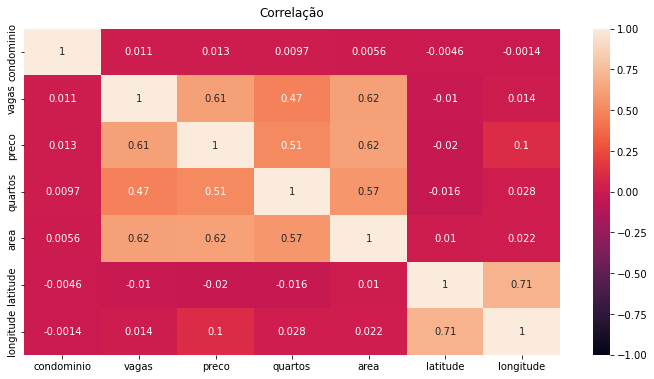

In [12]:
# Correlação
plt.figure(figsize=(12, 6))
hm = sns.heatmap(bh.corr(), vmin=-1, vmax=1, annot=True)
hm.set_title('Correlação', pad=12);
plt.show()

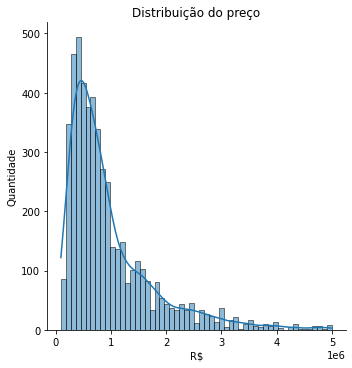

In [13]:
# Distribuição do preço
sns.displot(bh.preco, kde=True)
plt.title("Distribuição do preço")
plt.xlabel("R$")
plt.ylabel("Quantidade")
plt.show()

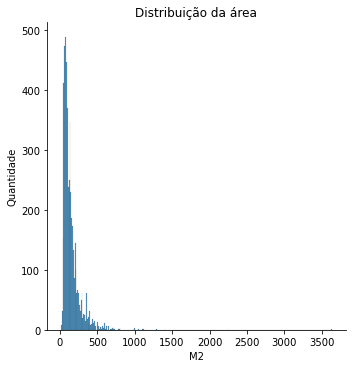

In [14]:
# Distribuição da área
sns.displot(bh.area)
plt.title("Distribuição da área")
plt.xlabel("M2")
plt.ylabel("Quantidade")
plt.show()

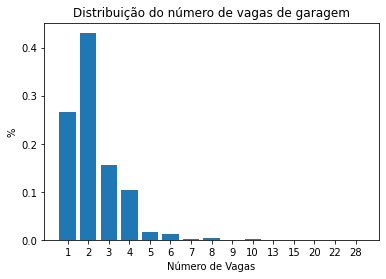

In [15]:
# Distribuição do número de vagas
vagas = bh.vagas.value_counts().sort_index()

plt.bar([str(value) for value in vagas.index],  vagas.values / bh.shape[0])
plt.title("Distribuição do número de vagas de garagem")
plt.xlabel("Número de Vagas")
plt.ylabel("%")
plt.show()

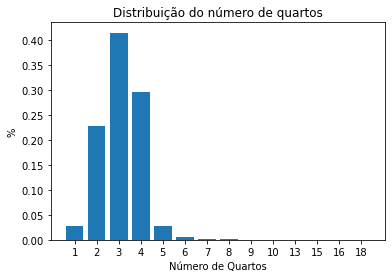

In [16]:
# Distribuição do número de quartos
quartos = bh.quartos.value_counts().sort_index()

plt.bar([str(value) for value in quartos.index],  quartos.values / bh.shape[0])
plt.title("Distribuição do número de quartos")
plt.xlabel("Número de Quartos")
plt.ylabel("%")
plt.show()

In [17]:
_random_state = 1

def exec_model(name, modelo, x, y, n_splits, funcs):
    global res
    scores = cross_validate(modelo, x, y, scoring=_scoring, cv=n_splits, n_jobs=-1)
    vals = {'Regressor': name}
    for s in _scoring:
        _scores = scores['test_' + s]
        for f in funcs:
            vals[f.__name__ + '_' + s] = f(_scores)
    res = pd.concat([res, pd.Series(vals).to_frame().T])

def exec_models(X, y, x_type, n_splits=10, funcs=[mean, min, max]):
    for m in _models:
        exec_model(m.__class__.__name__ + '_' + x_type, clone(m), X, y, n_splits, funcs)

In [18]:
bh2 = bh
cols_to_drop = ['preco','endereco','bairro']
_X = bh2.drop(columns=cols_to_drop)
_y = bh2['preco']
res = pd.DataFrame(columns=['Regressor'])
_scoring = ['r2']
_models = [LinearRegression(), DecisionTreeRegressor(random_state=_random_state), RandomForestRegressor(random_state=_random_state), ExtraTreesRegressor(n_estimators=100, random_state=_random_state), GradientBoostingRegressor(random_state=_random_state)]
Xs = {"normal_X": _X}

for k, v in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(v, _y, test_size=0.30, random_state=_random_state)
    exec_models(X_train, y_train, k, n_splits=5)

res.sort_values(['mean_r2'], ascending=False)

,Regressor,mean_r2,min_r2,max_r2
0,RandomForestRegressor_normal_X,0.825536,0.78247,0.853824
0,ExtraTreesRegressor_normal_X,0.813019,0.773613,0.833851
0,GradientBoostingRegressor_normal_X,0.802545,0.780863,0.822425
0,DecisionTreeRegressor_normal_X,0.702833,0.674843,0.753822
0,LinearRegression_normal_X,0.476343,0.391748,0.552236


In [19]:
bh2 = bh
# bairro - one hot encoding
dummies = pd.get_dummies(bh2.bairro, prefix='bai', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

# endereco - one hot encoding
dummies = pd.get_dummies(bh2.endereco, prefix='end', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

cols_to_drop = ['preco','endereco','bairro']
_X = bh2.drop(columns=cols_to_drop)
_y = bh2['preco']
res = pd.DataFrame(columns=['Regressor'])
_scoring = ['r2']
_models = [RandomForestRegressor(random_state=_random_state), ExtraTreesRegressor(n_estimators=100, random_state=_random_state), GradientBoostingRegressor(random_state=_random_state)]
Xs = {"normal_X": _X}

for k, v in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(v, _y, test_size=0.30, random_state=_random_state)
    exec_models(X_train, y_train, k, n_splits=5)

res.sort_values(['mean_r2'], ascending=False)

,Regressor,mean_r2,min_r2,max_r2
0,ExtraTreesRegressor_normal_X,0.836633,0.792674,0.859075
0,RandomForestRegressor_normal_X,0.831068,0.78351,0.855813
0,GradientBoostingRegressor_normal_X,0.804662,0.778191,0.819001


In [20]:
bh2 = bh
# bairro - one hot encoding
dummies = pd.get_dummies(bh2.bairro, prefix='bai', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

# endereco - one hot encoding
dummies = pd.get_dummies(bh2.endereco, prefix='end', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

cols_to_drop = ['preco','endereco','bairro','quartos']
_X = bh2.drop(columns=cols_to_drop)
_y = bh2['preco']
res = pd.DataFrame(columns=['Regressor'])
_scoring = ['r2']
_models = [RandomForestRegressor(random_state=_random_state), ExtraTreesRegressor(n_estimators=100, random_state=_random_state), GradientBoostingRegressor(random_state=_random_state)]
Xs = {"normal_X": _X}

for k, v in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(v, _y, test_size=0.30, random_state=_random_state)
    exec_models(X_train, y_train, k, n_splits=5)

res.sort_values(['mean_r2'], ascending=False)

,Regressor,mean_r2,min_r2,max_r2
0,ExtraTreesRegressor_normal_X,0.832762,0.782652,0.856555
0,RandomForestRegressor_normal_X,0.830659,0.783088,0.856492
0,GradientBoostingRegressor_normal_X,0.802858,0.775946,0.818584


In [21]:
bh2 = bh
# bairro - one hot encoding
dummies = pd.get_dummies(bh2.bairro, prefix='bai', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

# endereco - one hot encoding
dummies = pd.get_dummies(bh2.endereco, prefix='end', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

cols_to_drop = ['preco','endereco','bairro']
_X = bh2.drop(columns=cols_to_drop)
_y = bh2['preco']
res = pd.DataFrame(columns=['Regressor'])
_scoring = ['r2']
_models = [RandomForestRegressor(random_state=_random_state), ExtraTreesRegressor(n_estimators=100, random_state=_random_state), GradientBoostingRegressor(random_state=_random_state)]

standard_X = StandardScaler().fit_transform(_X)
minmax_X = MinMaxScaler().fit_transform(_X)
Xs = {"normal_X": _X, "standard_X": standard_X, "minmax_X": minmax_X}

for k, v in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(v, _y, test_size=0.30, random_state=_random_state)
    exec_models(X_train, y_train, k, n_splits=5)

res.sort_values(['mean_r2'], ascending=False)

,Regressor,mean_r2,min_r2,max_r2
0,ExtraTreesRegressor_normal_X,0.836633,0.792674,0.859075
0,ExtraTreesRegressor_minmax_X,0.836121,0.793488,0.856475
0,ExtraTreesRegressor_standard_X,0.835989,0.793117,0.855721
0,RandomForestRegressor_normal_X,0.831068,0.78351,0.855813
0,RandomForestRegressor_standard_X,0.83091,0.783146,0.854645
0,RandomForestRegressor_minmax_X,0.830777,0.783325,0.85493
0,GradientBoostingRegressor_standard_X,0.804815,0.778572,0.819395
0,GradientBoostingRegressor_minmax_X,0.804726,0.778572,0.819001
0,GradientBoostingRegressor_normal_X,0.804662,0.778191,0.819001


In [22]:
bh2 = bh
# bairro - one hot encoding
dummies = pd.get_dummies(bh2.bairro, prefix='bai', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

# endereco - one hot encoding
dummies = pd.get_dummies(bh2.endereco, prefix='end', drop_first=True)
bh2 = pd.concat([bh2, dummies], axis=1)

cols_to_drop = ['preco','endereco','bairro']
_X = bh2.drop(columns=cols_to_drop)
_y = bh2['preco']
res = pd.DataFrame(columns=['Regressor'])
_scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
_models = [RandomForestRegressor(random_state=_random_state), ExtraTreesRegressor(n_estimators=100, random_state=_random_state), GradientBoostingRegressor(random_state=_random_state)]

Xs = {"normal_X": _X}

for k, v in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(v, _y, test_size=0.30, random_state=_random_state)
    exec_models(X_train, y_train, k, n_splits=5, funcs=[mean])

res.sort_values(['mean_r2'], ascending=False)

,Regressor,mean_r2,mean_neg_mean_squared_error,mean_neg_root_mean_squared_error
0,ExtraTreesRegressor_normal_X,0.836633,-103168532643.611053,-320120.88907
0,RandomForestRegressor_normal_X,0.831068,-106114471441.939484,-325046.24699
0,GradientBoostingRegressor_normal_X,0.804662,-122990752058.283691,-350380.767749


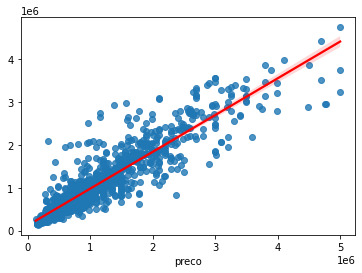

In [23]:
# Modelo que melhor generalizou
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.30, random_state=_random_state)
m = ExtraTreesRegressor(n_estimators=100, min_samples_split=5)

model = clone(m)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
sns.regplot(x=y_test, y=y_predict, line_kws={'color': 'red'})
plt.show()

/Users/user/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


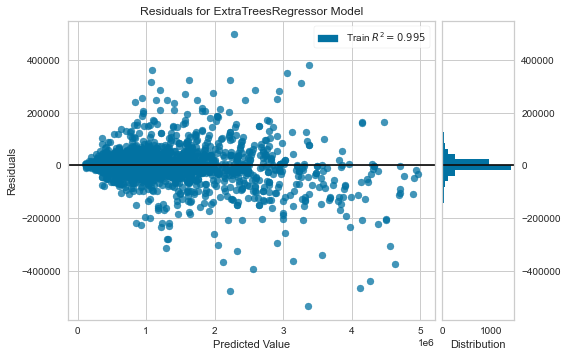

<AxesSubplot:title={'center':'Residuals for ExtraTreesRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [24]:
from yellowbrick.regressor import ResidualsPlot

model = ResidualsPlot(model)
model.fit(X_train, y_train)
model.show()
